In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from ripple_heterogeneity.utils import reduced_rank_regressor,kernel_reduced_rank_ridge_regression
from ripple_heterogeneity.utils import custom_plots
import numpy as np
import seaborn as sns


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:

# simulate data with rank 16 dims
X, Y = reduced_rank_regressor.ideal_data(1000,500,100,16,noise=5)
# used reduced rank regressor to fit data over multiple ranks
score = []
for i in range(1,100):
    rrr = reduced_rank_regressor.ReducedRankRegressor(X,Y,i)
    score.append(rrr.score(X,Y))

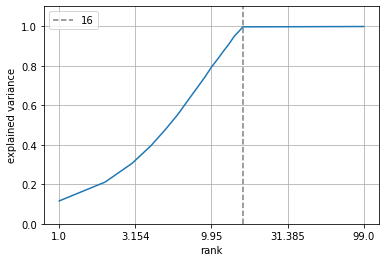

In [5]:

x = range(1, 100)
plt.plot(np.log10(x), score)

ax = plt.gca()
custom_plots.restore_natural_scale(
    ax, np.min(np.log10(x)), np.max(np.log10(x)), n_steps=5, x_axis=True, y_axis=False
)

plt.axvline(np.log10(16), color="grey", linestyle="--", label=16)
plt.xlabel("rank")
plt.ylabel("explained variance")
plt.legend()
plt.ylim(0,1.1)
plt.grid()

<AxesSubplot:>

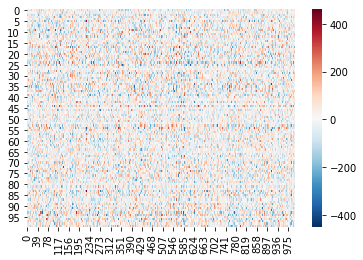

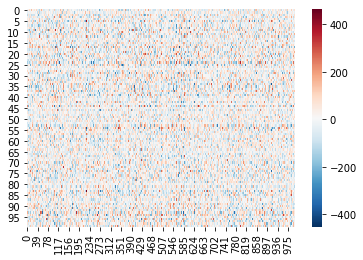

In [6]:
rrr = reduced_rank_regressor.ReducedRankRegressor(X,Y,16)
y_pred = rrr.predict(X)

plt.figure()
sns.heatmap(Y.T,cmap="RdBu_r")
plt.figure()

sns.heatmap(y_pred.T,cmap="RdBu_r")

In [9]:
X, Y = reduced_rank_regressor.ideal_data(1000,500,100,16,noise=5)

score = []
for i in range(1,100):
    rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
    rrr.rank = i
    rrr.reg = 1
    rrr.fit(X,Y)
    score.append(rrr.score(X,Y))


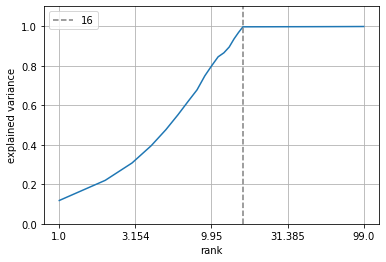

In [10]:
x = range(1, 100)
plt.plot(np.log10(x), score)

ax = plt.gca()
custom_plots.restore_natural_scale(
    ax, np.min(np.log10(x)), np.max(np.log10(x)), n_steps=5, x_axis=True, y_axis=False
)

plt.axvline(np.log10(16), color="grey", linestyle="--", label=16)
plt.xlabel("rank")
plt.ylabel("explained variance")
plt.legend()
plt.ylim(0,1.1)
plt.grid()

In [40]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def evaluate(model, X, y, cv, verbose=False):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    if verbose:

        print(
            f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
            f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
            f"R2:                      {r2.mean():.3f} +/- {r2.std():.3f}"
        )
    return mae, rmse, r2


ts_cv = TimeSeriesSplit(n_splits=5)

X, Y = reduced_rank_regressor.ideal_data(1000, 500, 100, 16, noise=5)

rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
rrr.rank = 16

mae, rmse, r2 = evaluate(rrr, X, Y, cv=ts_cv, verbose=True)


Mean Absolute Error:     23.655 +/- 21.283
Root Mean Squared Error: 29.636 +/- 26.673
R2:                      0.794 +/- 0.261


In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=True
)
rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()

folds = TimeSeriesSplit(n_splits=5)
parameters_grid_search = {"rank": np.arange(1, 65).astype(int)}
model_cv = GridSearchCV(
    rrr,
    parameters_grid_search,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    verbose=True,
    return_train_score=True
)
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=ReducedRankRegressor(), n_jobs=-1,
             param_grid={'rank': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [71]:
cv_results.keys()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_rank', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

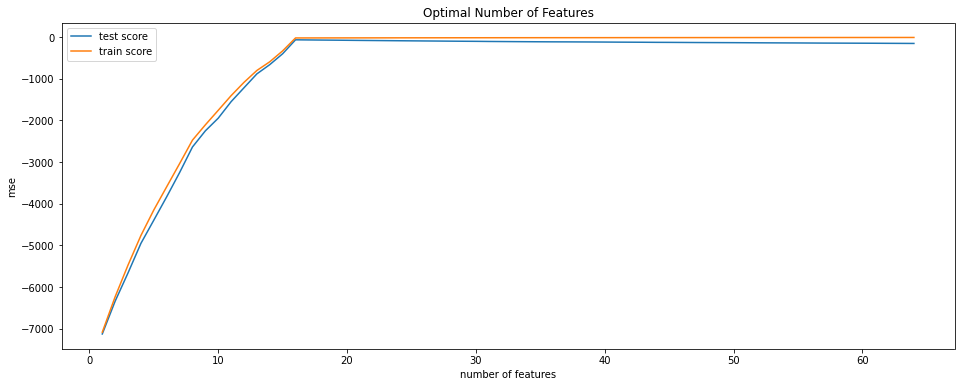

In [89]:
# cv results
import pandas as pd
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_rank"], cv_results["mean_test_score"])
plt.plot(cv_results["param_rank"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('mse')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [90]:
rrr.rank=16
evaluate(rrr, X_test, y_test, folds, verbose=True)
# rrr.fit(X_train,y_train)

Mean Absolute Error:     60.187 +/- 5.292
Root Mean Squared Error: 75.195 +/- 6.954
R2:                      0.279 +/- 0.120


(array([65.52288736, 65.24297972, 60.75051388, 58.29133803, 51.12811085]),
 array([82.10939125, 82.10155997, 75.76950217, 72.6008276 , 63.39435035]),
 array([0.15194822, 0.1836086 , 0.26420468, 0.30195933, 0.49449261]))

In [48]:
rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()

mae, rmse, r2 = evaluate(rrr, X_test, y_test, cv=ts_cv, verbose=True)


Mean Absolute Error:     59.072 +/- 6.672
Root Mean Squared Error: 73.786 +/- 8.296
R2:                      0.300 +/- 0.141


In [47]:
print(mean_squared_error(y_test, rrr.predict(X_test), squared=True))
# rrr.score(X,Y)
print(mean_squared_error(y_train, rrr.predict(X_train), squared=True))
print(r2_score(y_test, rrr.predict(X_test)))


49.27043012668276
21.11148787589491
0.9935498654568332


In [61]:
from sklearn.model_selection import GridSearchCV
rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
from sklearn.model_selection import cross_val_score

rank_grid = np.arange(1, 64).astype(
    int
)

parameters_grid_search = {"rank": rank_grid}

cv_inner = TimeSeriesSplit(n_splits=2)

search = GridSearchCV(rrr, parameters_grid_search, scoring='neg_mean_squared_error', n_jobs=1, cv=cv_inner, refit=True)

cv_outer = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(search, X, Y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)


In [62]:
scores

array([-5522.12284843, -2423.31438746,  -244.54488116,   -37.89116316,
         -31.22608768])

In [92]:
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
                    
mdl = PLSRegression()
parameters_grid_search = {"n_components": np.arange(1, 65).astype(int)}

model_cv = GridSearchCV(
    mdl,
    parameters_grid_search,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    verbose=True,
    return_train_score=True
)
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=PLSRegression(), n_jobs=-1,
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [94]:
cv_results.keys()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

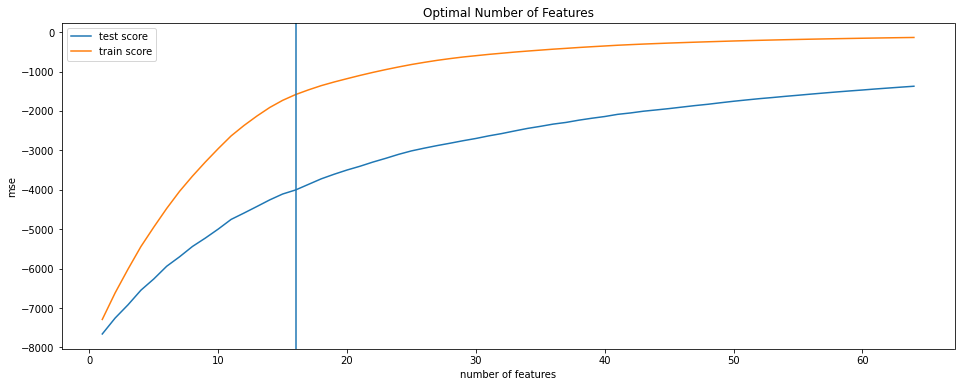

In [97]:
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_components"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_components"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('mse')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.axvline(16)

In [98]:
mdl.n_components=16
evaluate(mdl, X_test, y_test, folds, verbose=True)

Mean Absolute Error:     64.281 +/- 2.846
Root Mean Squared Error: 80.229 +/- 3.859
R2:                      0.188 +/- 0.072


(array([67.53426764, 66.72332363, 64.90704996, 62.45567613, 59.78355456]),
 array([84.3316326 , 84.11086936, 80.78163156, 77.66811275, 74.25470592]),
 array([0.10418163, 0.14516593, 0.16751937, 0.2068371 , 0.31632314]))

In [102]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    X_train, y_train)

In [103]:
reg.score(X_test, y_test)

0.03100946744736318

<AxesSubplot:>

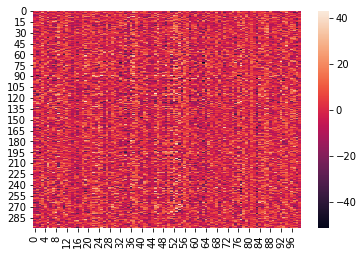

In [105]:
sns.heatmap(reg.predict(X_test))